In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

import requests
from bs4 import BeautifulSoup

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', None)

# Data Analysis

### Which station has the most number of units?

Preliminary analysis shows that two columns between the 'Remote-Booth-Stations.xls', which is the table containing the names of the stations, and the turnstile data have different names, despite referring to the same entity. The following show the equivalent columns, with the 'Remote-Booth-Stations.xls' column name first:
1. Remote--C/A
2. Booth--UNIT

In addition, the data shows that there is an column called 'SCP', which references to each individual turnstile. The overarching spheres of labeling each individual turnstiles is the following from least to most granular: UNIT > C/A > SCP. As a result, we will be evaluating which station has the most number of individual turnstile units by looking at 'SCP'. In addition, I will be using the latest data file for this question, which is important to note because some stations may have added turnstiles from previous years.

In [2]:
key = pd.read_excel('http://web.mta.info/developers/resources/nyct/turnstile/Remote-Booth-Station.xls')
key = key.rename(columns={'Remote':'UNIT', 'Booth':'C/A'})

In [3]:
raw_12_08_18 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_181208.txt')

In [4]:
unique_turnstiles = raw_12_08_18[['C/A', 'UNIT', 'SCP', 'STATION']].drop_duplicates().reset_index(drop=True)

In [5]:
print(unique_turnstiles.groupby('STATION').count()['SCP'].idxmax())
print(unique_turnstiles.groupby('STATION').count()['SCP'].max())

34 ST-PENN STA
100


### What is the total number of entries & exits across the subway system for February 1, 2013?

In [6]:
# field_description taken from http://web.mta.info/developers/resources/nyct/turnstile/ts_Field_Description_pre-10-18-2014.txt
field_description = 'C/A,UNIT,SCP,DATE1,TIME1,DESC1,ENTRIES1,EXITS1,DATE2,TIME2,DESC2,ENTRIES2,EXITS2,DATE3,TIME3,DESC3,ENTRIES3,EXITS3,DATE4,TIME4,DESC4,ENTRIES4,EXITS4,DATE5,TIME5,DESC5,ENTRIES5,EXITS5,DATE6,TIME6,DESC6,ENTRIES6,EXITS6,DATE7,TIME7,DESC7,ENTRIES7,EXITS7,DATE8,TIME8,DESC8,ENTRIES8,EXITS8'
columns = field_description.split(',')


In [7]:
raw_02_02_13 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_130202.txt',
                           names=columns)

In [8]:
raw_02_09_13 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_130209.txt',
                           names=columns )

In [9]:
raw_02_02_13 = pd.concat([raw_02_02_13, raw_02_09_13])

In [10]:
#Since the data has 43 columns, where some of the columns have the same type of information, we will need to reshape
#the data to make it easier to work with. To do this we separate the data into blocks and concat them as rows

df_02_02_13 = raw_02_02_13[['C/A', 'UNIT', 'SCP', 'DATE1', 'TIME1', 'DESC1', 'ENTRIES1', 'EXITS1']]
df_02_02_13 = df_02_02_13.rename(columns={'DATE1':'DATE', 'TIME1': 'TIME', 'DESC1': 'DESC', 'ENTRIES1': 'ENTRIES',
                                          'EXITS1': 'EXITS'})
for i in range(2,9):
    table = raw_02_02_13.loc[:,['DATE' + str(i), 
                                'TIME' + str(i),
                                'DESC' + str(i),
                                'ENTRIES' + str(i),
                                'EXITS' + str(i)]]
    table = table.rename(columns={'DATE' + str(i):'DATE', 
                                  'TIME' + str(i):'TIME',
                                  'DESC' + str(i):'DESC',
                                  'ENTRIES' + str(i):'ENTRIES',
                                  'EXITS' + str(i):'EXITS'})
    table['C/A'] = raw_02_02_13['C/A']
    table['UNIT'] = raw_02_02_13['UNIT']
    table['SCP'] = raw_02_02_13['SCP']
    
    df_02_02_13 = pd.concat([df_02_02_13, table], sort=True)
    print('Added block %s' %(i))
df_02_02_13 = df_02_02_13.merge(key, how='left')
print('New shape: (%s,%s)' %(df_02_02_13.shape[0],df_02_02_13.shape[1]))

Added block 2
Added block 3
Added block 4
Added block 5
Added block 6
Added block 7
Added block 8
New shape: (483000,11)


In [11]:
feb_1 = df_02_02_13[(df_02_02_13['DATE'] == '02-01-13')].sort_values(by=['C/A', 'UNIT', 'SCP', 'DATE', 'TIME'])

It's important to note that not this doesn't include EVERY single ride that occured on 02-01-2013. This is because there are some counts that are overlapped on 1-31-13 and 02-02-13. For example, if record shows that it was recorded at 3:00:00 on 02-01-13, there are 3 missing hours. It is expected that the record would be shown on 1-31-13. As a result, we will be adding those times back, allocating the count evenly per hour for each count.

In [12]:
# Get last entry on 1/31/13, as long as it is later than 20:00:00 (since scheduled shifts are every 4 hours)
desired_1_31_13 = df_02_02_13[((df_02_02_13['DATE'] == '01-31-13') &
                              (df_02_02_13['TIME'] > '20:00:00'))].groupby(['C/A', 'UNIT', 
                                                                            'SCP', 'DATE'])['TIME'].max().reset_index()
desired_1_31_13 = desired_1_31_13.merge(df_02_02_13, how = 'left')
# Get first entry on 2/2/13, as long as it is earlier than 04:00:00 (since schedule shifts are every 4 hours)
desired_2_02_13 = df_02_02_13[((df_02_02_13['DATE'] == '02-02-13') &
                              (df_02_02_13['TIME'] < '04:00:00'))].groupby(['C/A', 'UNIT', 
                                                                            'SCP', 'DATE'])['TIME'].min().reset_index()
desired_2_02_13 = desired_2_02_13.merge(df_02_02_13, how = 'left')

In [13]:
# Concat the dataframes together (total date is 1-31-2013(latest time) through 2-20-2013(earliest time))
feb_1_full = pd.concat([feb_1, desired_1_31_13, desired_2_02_13], sort=False, ignore_index = True)
feb_1_full = feb_1_full.sort_values(by = ['C/A', 'UNIT', 'SCP', 'DATE', 'TIME']).reset_index(drop=True)

#Remove the same timed inspections, but with different reasons
feb_1_full = feb_1_full.drop_duplicates(subset = ['C/A', 'UNIT', 'SCP', 'DATE', 'TIME']).reset_index(drop=True)

In [14]:
# An examaple of a complete reocord of a turnstile on February 1st:
feb_1_full.head(8)

,C/A,DATE,DESC,ENTRIES,EXITS,SCP,TIME,UNIT,Station,Line Name,Division
0,A002,01-31-13,REGULAR,3974506.0,1369951.0,02-00-00,23:00:00,R051,LEXINGTON AVE,456NQR,BMT
1,A002,02-01-13,REGULAR,3974506.0,1369951.0,02-00-00,03:00:00,R051,LEXINGTON AVE,456NQR,BMT
2,A002,02-01-13,REGULAR,3974518.0,1369972.0,02-00-00,07:00:00,R051,LEXINGTON AVE,456NQR,BMT
3,A002,02-01-13,REGULAR,3974706.0,1370294.0,02-00-00,11:00:00,R051,LEXINGTON AVE,456NQR,BMT
4,A002,02-01-13,REGULAR,3974913.0,1370326.0,02-00-00,15:00:00,R051,LEXINGTON AVE,456NQR,BMT
5,A002,02-01-13,REGULAR,3975747.0,1370378.0,02-00-00,19:00:00,R051,LEXINGTON AVE,456NQR,BMT
6,A002,02-01-13,REGULAR,3976035.0,1370406.0,02-00-00,23:00:00,R051,LEXINGTON AVE,456NQR,BMT
7,A002,02-02-13,REGULAR,3976080.0,1370415.0,02-00-00,03:00:00,R051,LEXINGTON AVE,456NQR,BMT


In [15]:
feb_1_full['ENTRIES_DIFF'] = feb_1_full.groupby(['C/A', 'UNIT', 'SCP'])['ENTRIES'].diff()
feb_1_full['EXITS_DIFF'] = feb_1_full.groupby(['C/A', 'UNIT', 'SCP'])['EXITS'].diff()

Although using pd.DataFrame.diff() allowed us get the difference between turnstile check time, we know that some of the turnstiles resetted in the middle of the day. We will be assuming that the turnstile resetted immediately after the previous check and will be taking the count as the new value after the reset. An example of a resetted turnstile is shown below: 

In [16]:
feb_1_full[(feb_1_full['C/A'] == 'PTH03') &  (feb_1_full['UNIT'] == 'R552') &
      (feb_1_full['SCP'] == '00-00-08')]

,C/A,DATE,DESC,ENTRIES,EXITS,SCP,TIME,UNIT,Station,Line Name,Division,ENTRIES_DIFF,EXITS_DIFF
20169,PTH03,01-31-13,REGULAR,835854.0,443532.0,00-00-08,23:00:04,R552,JOURNAL SQUARE,1,PTH,NaN,NaN
20170,PTH03,02-01-13,REGULAR,835872.0,443580.0,00-00-08,03:12:04,R552,JOURNAL SQUARE,1,PTH,18.0,48.0
20171,PTH03,02-01-13,DOOR OPEN,836152.0,443594.0,00-00-08,06:51:42,R552,JOURNAL SQUARE,1,PTH,280.0,14.0
20172,PTH03,02-01-13,LOGON,836152.0,443594.0,00-00-08,06:51:49,R552,JOURNAL SQUARE,1,PTH,0.0,0.0
20173,PTH03,02-01-13,REGULAR,836319.0,443602.0,00-00-08,07:24:04,R552,JOURNAL SQUARE,1,PTH,167.0,8.0
20174,PTH03,02-01-13,REGULAR,837363.0,443630.0,00-00-08,09:44:04,R552,JOURNAL SQUARE,1,PTH,1044.0,28.0
20175,PTH03,02-01-13,REGULAR,348.0,46.0,00-00-08,13:44:38,R552,JOURNAL SQUARE,1,PTH,-837015.0,-443584.0
20176,PTH03,02-01-13,REGULAR,1051.0,383.0,00-00-08,17:56:38,R552,JOURNAL SQUARE,1,PTH,703.0,337.0
20177,PTH03,02-01-13,REGULAR,1446.0,904.0,00-00-08,22:08:38,R552,JOURNAL SQUARE,1,PTH,395.0,521.0
20178,PTH03,02-02-13,REGULAR,1541.0,1043.0,00-00-08,02:20:38,R552,JOURNAL SQUARE,1,PTH,95.0,139.0


In [17]:
def replace_resetted_turnstile(row, typ):
        if row[typ + '_DIFF'] < 0:
            return row[typ]
        else:
            return row[typ + '_DIFF']
    
feb_1_full['ENTRIES_DIFF'] = feb_1_full.apply(replace_resetted_turnstile, typ ='ENTRIES', axis=1)
feb_1_full['EXITS_DIFF'] = feb_1_full.apply(replace_resetted_turnstile, typ = 'EXITS', axis=1)


We also noticed that some datapoints are negative, as seen here: 

In [18]:
feb_1_full[(feb_1_full['ENTRIES'] < 0) | (feb_1_full['EXITS'] < 0)].head()

,C/A,DATE,DESC,ENTRIES,EXITS,SCP,TIME,UNIT,Station,Line Name,Division,ENTRIES_DIFF,EXITS_DIFF
12403,N182,01-31-13,REGULAR,-678014840.0,-644464144.0,00-03-01,20:48:34,R414,HOWARD BCH-JFK,A,IND,NaN,NaN
12404,N182,02-01-13,REGULAR,-678014738.0,-644464014.0,00-03-01,00:00:00,R414,HOWARD BCH-JFK,A,IND,102.0,130.0
12405,N182,02-01-13,RECOVR AUD,-678014697.0,-644463964.0,00-03-01,04:00:00,R414,HOWARD BCH-JFK,A,IND,41.0,50.0
12406,N182,02-01-13,REGULAR,-678014424.0,-644463895.0,00-03-01,07:11:13,R414,HOWARD BCH-JFK,A,IND,273.0,69.0
12407,N182,02-01-13,REGULAR,-678014237.0,-644463841.0,00-03-01,08:00:00,R414,HOWARD BCH-JFK,A,IND,187.0,54.0


Although the ENTRIES and EXITS counts are negative, we see that the numbers do increase over time. Thus, the ENTRIES_DIFF column still is valid to evaluate the count. It is important to keep in mind of this possible error because although allowing this method is valid for analysis of one day, it will become a problem when we look at larger datasets such as one that take place over a year. 

We are going to collect the rows that are affected by previous day's data numbers. In other words, we collect the hours missing from the bookends times of 2-1-2013 (Midnight to 3AM is often shown on 1-31-2013, while 8PM to 12AM is usually found on 2-2-2013)

In [19]:
feb_1_full['date_time'] = pd.to_datetime(feb_1_full['DATE'] + ' ' + feb_1_full['TIME'])

In [20]:
data_01_31_13 = [row.name + 1 for index, row in feb_1_full[feb_1_full['DATE'] == '01-31-13'].iterrows()]
data_02_02_13 = [row.name for index, row in feb_1_full[feb_1_full['DATE'] == '02-02-13'].iterrows()]

In [21]:
def remove_count_from_feb_1(row, table):
    midnight_02_01 = pd.to_datetime('02/01/2013 00:00:00')
    midnight_02_02 = pd.to_datetime('02/02/2013 00:00:00')
    if row.name in data_01_31_13:
        gap = (table.iloc[row.name]['date_time'] - table.iloc[row.name-1]['date_time']).total_seconds()/3600
        correct_hours = (table.iloc[row.name]['date_time'] - midnight_02_01).total_seconds()/3600
        return correct_hours/gap
    elif row.name in data_02_02_13:
        gap = (table.iloc[row.name]['date_time'] - table.iloc[row.name-1]['date_time']).total_seconds()/3600
        correct_hours = (midnight_02_02 - table.iloc[row.name-1]['date_time']).total_seconds()/3600
        return correct_hours/gap
    else:
        return 1

In [22]:
feb_1_full['factor'] = feb_1_full.apply(remove_count_from_feb_1, table = feb_1_full, axis=1)

In [23]:
feb_1_full = feb_1_full.fillna(0)

In [24]:
feb_1_full['ENTRIES_complete'] = feb_1_full['ENTRIES_DIFF'] * feb_1_full['factor']
feb_1_full['EXITS_complete'] = feb_1_full['EXITS_DIFF'] * feb_1_full['factor']

In [25]:
print('Entries: %s, Exits: %s'%(int(feb_1_full['ENTRIES_complete'].sum()), int(feb_1_full['EXITS_complete'].sum())))

Entries: 86770736, Exits: 4541717


The number of entries and exits seems wildly off. After some investigation, we see that there a glitch in the system at BEDFORD/NOSTRAND station. Specifically it is in the below turnstile:

In [26]:
feb_1_full[(feb_1_full['Station'] == 'BEDFORD/NOSTRAN') & 
      (feb_1_full['C/A'] == 'N418') &
      (feb_1_full['SCP'] == '01-06-00')].sort_values(['C/A', 'UNIT', 
                                                      'SCP', 'DATE', 'TIME']).reset_index(drop=True).iloc[10:14]

,C/A,DATE,DESC,ENTRIES,EXITS,SCP,TIME,UNIT,Station,Line Name,Division,ENTRIES_DIFF,EXITS_DIFF,date_time,factor,ENTRIES_complete,EXITS_complete
10,N418,02-01-13,DOOR OPEN,2981870.0,3006458.0,01-06-00,14:47:59,R269,BEDFORD/NOSTRAN,G,IND,0.0,30.0,2013-02-01 14:47:59,1.0,0.0,30.0
11,N418,02-01-13,LOGON,2981870.0,3006458.0,01-06-00,14:48:56,R269,BEDFORD/NOSTRAN,G,IND,0.0,0.0,2013-02-01 14:48:56,1.0,0.0,0.0
12,N418,02-01-13,LGF-MAN,2981870.0,3006458.0,01-06-00,14:49:15,R269,BEDFORD/NOSTRAN,G,IND,0.0,0.0,2013-02-01 14:49:15,1.0,0.0,0.0
13,N418,02-01-13,DOOR CLOSE,83886080.0,0.0,01-06-00,14:51:51,R269,BEDFORD/NOSTRAN,G,IND,80904210.0,0.0,2013-02-01 14:51:51,1.0,80904210.0,0.0


According to http://web.mta.info/nyct/facts/ridership/, the average number of people who use the subway on a weekday is around 5.5 million, with the highest being 6.1 million in a day. Putting a limiting bench mark, such as spike of more than 7,000 counts (for a single turnstile in a single period max of 4 hours) would be a likely indication that this turnstile is malfunctioning. 7,000 was chosen as a number because it was a number that is low enough to catch the errors of malfunctioning machines, while high enough to not exclude valid values. 

In [27]:
feb_1_final = feb_1_full[(abs(feb_1_full['ENTRIES_complete']) < 7000) &
                    (abs(feb_1_full['EXITS_complete'] < 7000))].sort_values(by = ['C/A', 'UNIT', 'SCP', 'DATE', 'TIME'])

In [28]:
#feb_1_final

In [29]:
print('Entries: %s, Exits: %s' % (int(feb_1_final['ENTRIES_DIFF'].sum()), 
                                  int(feb_1_final['EXITS_DIFF'].sum())))

Entries: 6015153, Exits: 4685436


### Let’s define the busy-ness as sum of entry & exit count. What station was the busiest on February 1, 2013? What turnstile was the busiest on that date?



In [30]:
feb_1_final['busyness'] = feb_1_final['ENTRIES_complete'] + feb_1_final['EXITS_complete']

In [31]:
print('Busiest station: %s'%(feb_1_final.groupby('Station').sum()['busyness'].idxmax()))

Busiest station: 34 ST-PENN STA


In [32]:
print('Busiest turnstile:' + str(feb_1_final.groupby(['C/A', 
                                                      'UNIT', 'SCP']).sum().sort_values(by = 'busyness', 
                                                                                        ascending=False).index[0]))

Busiest turnstile:('R240', 'R047', '00-00-00')


In [33]:
feb_1_final[(feb_1_final['C/A'] == 'R240') & 
            (feb_1_final['UNIT'] == 'R047') &
            (feb_1_final['SCP'] == '00-00-00')][['C/A', 'UNIT', 'SCP', 'Station', 'Line Name']].head(1)

,C/A,UNIT,SCP,Station,Line Name
28565,R240,R047,00-00-00,42 ST-GRD CNTRL,4567S


In [34]:
feb_1_final[(feb_1_final['C/A'] == 'R240') & 
            (feb_1_final['UNIT'] == 'R047') &
            (feb_1_final['SCP'] == '00-00-00')]

,C/A,DATE,DESC,ENTRIES,EXITS,SCP,TIME,UNIT,Station,Line Name,Division,ENTRIES_DIFF,EXITS_DIFF,date_time,factor,ENTRIES_complete,EXITS_complete,busyness
28565,R240,02-01-13,REGULAR,262733.0,643461.0,00-00-00,00:00:00,R047,42 ST-GRD CNTRL,4567S,IRT,0.0,0.0,2013-02-01 00:00:00,1.0,0.0,0.0,0.0
28566,R240,02-01-13,REGULAR,262875.0,643556.0,00-00-00,04:00:00,R047,42 ST-GRD CNTRL,4567S,IRT,142.0,95.0,2013-02-01 04:00:00,1.0,142.0,95.0,237.0
28567,R240,02-01-13,REGULAR,262960.0,644906.0,00-00-00,08:00:00,R047,42 ST-GRD CNTRL,4567S,IRT,85.0,1350.0,2013-02-01 08:00:00,1.0,85.0,1350.0,1435.0
28568,R240,02-01-13,REGULAR,263151.0,649210.0,00-00-00,12:00:00,R047,42 ST-GRD CNTRL,4567S,IRT,191.0,4304.0,2013-02-01 12:00:00,1.0,191.0,4304.0,4495.0
28569,R240,02-01-13,REGULAR,263889.0,651537.0,00-00-00,16:00:00,R047,42 ST-GRD CNTRL,4567S,IRT,738.0,2327.0,2013-02-01 16:00:00,1.0,738.0,2327.0,3065.0
28570,R240,02-01-13,REGULAR,266084.0,652282.0,00-00-00,20:00:00,R047,42 ST-GRD CNTRL,4567S,IRT,2195.0,745.0,2013-02-01 20:00:00,1.0,2195.0,745.0,2940.0
28571,R240,02-02-13,REGULAR,266718.0,652950.0,00-00-00,00:00:00,R047,42 ST-GRD CNTRL,4567S,IRT,634.0,668.0,2013-02-02 00:00:00,1.0,634.0,668.0,1302.0


### What stations have seen the most usage growth/decline in 2013?

In [35]:
r = requests.get('http://web.mta.info/developers/turnstile.html')
soup = BeautifulSoup(r.text, 'html.parser')
data_links = [a['href'] for a in soup.find_all('a', 
                                               href=True) if a['href'].startswith('data/nyct/turnstile/turnstile_13')]
print('Sample of url tail retrieved: ' + str(data_links[0]))

Sample of url tail retrieved: data/nyct/turnstile/turnstile_131228.txt


We also wanted to add the bookends of the dataset as well, like we do with time for Feburary 1st. However, we will not go through the motions of taking out the extra hours because we are going to be comparing the stations, which will be subjected the same noise. It's not worth combing through the data with that fine of detail when we are looking at a whole year for analysis.

In [38]:
data_links.append('data/nyct/turnstile/turnstile_140104.txt')

In [39]:
# write to csv for each one of them (do not need to worry about different dimensions because that happens in 2014)
link = 'http://web.mta.info/developers/'
dfs = []
for i in data_links:
    dfs.append(pd.read_csv(link + i, names=columns, ))
    print('Added %s to data_2013' %(i))
    
# Concatenate all data into one DataFrame
raw_2013 = pd.concat(dfs, ignore_index=True)


Added data/nyct/turnstile/turnstile_131228.txt to data_2013
Added data/nyct/turnstile/turnstile_131221.txt to data_2013
Added data/nyct/turnstile/turnstile_131214.txt to data_2013
Added data/nyct/turnstile/turnstile_131207.txt to data_2013
Added data/nyct/turnstile/turnstile_131130.txt to data_2013
Added data/nyct/turnstile/turnstile_131123.txt to data_2013
Added data/nyct/turnstile/turnstile_131116.txt to data_2013
Added data/nyct/turnstile/turnstile_131109.txt to data_2013
Added data/nyct/turnstile/turnstile_131102.txt to data_2013
Added data/nyct/turnstile/turnstile_131026.txt to data_2013
Added data/nyct/turnstile/turnstile_131019.txt to data_2013
Added data/nyct/turnstile/turnstile_131012.txt to data_2013
Added data/nyct/turnstile/turnstile_131005.txt to data_2013
Added data/nyct/turnstile/turnstile_130928.txt to data_2013
Added data/nyct/turnstile/turnstile_130921.txt to data_2013
Added data/nyct/turnstile/turnstile_130914.txt to data_2013
Added data/nyct/turnstile/turnstile_1309

In [40]:
df_2013 = raw_2013[['C/A', 'UNIT', 'SCP', 'DATE1', 'TIME1', 'DESC1', 'ENTRIES1', 'EXITS1']]
df_2013 = df_2013.rename(columns={'DATE1':'DATE', 'TIME1': 'TIME', 'DESC1': 'DESC', 'ENTRIES1': 'ENTRIES',
                                          'EXITS1': 'EXITS'})
for i in range(2,9):
    table = raw_2013.loc[:,['DATE' + str(i), 
                                'TIME' + str(i),
                                'DESC' + str(i),
                                'ENTRIES' + str(i),
                                'EXITS' + str(i)]]
    table = table.rename(columns={'DATE' + str(i):'DATE', 
                                  'TIME' + str(i):'TIME',
                                  'DESC' + str(i):'DESC',
                                  'ENTRIES' + str(i):'ENTRIES',
                                  'EXITS' + str(i):'EXITS'})
    table['C/A'] = raw_2013['C/A']
    table['UNIT'] = raw_2013['UNIT']
    table['SCP'] = raw_2013['SCP']
    
    df_2013 = pd.concat([df_2013, table], sort=True)
    print('Added block %s' %(i))
print('New shape: (%s,%s)' %(df_2013.shape[0],df_2013.shape[1]))

Added block 2
Added block 3
Added block 4
Added block 5
Added block 6
Added block 7
Added block 8
New shape: (12609816,8)


In [41]:
df_2013['Datetime'] = pd.to_datetime(df_2013['DATE'].apply(str)+' '+df_2013['TIME'])
df_2013 = df_2013.merge(key, how = 'left')

In [43]:
desired_12_31_12 = df_2013[(df_2013['DATE']== '12-31-12') & 
                     (df_2013['TIME'] > '20:00:00')].groupby(['C/A', 'UNIT', 'SCP', 'DATE'])['TIME'].max().reset_index()
desired_12_31_12 = desired_12_31_12.merge(df_2013, how = 'left')

In [44]:
desired_1_1_14 = df_2013[(df_2013['DATE']== '01-01-14') & 
                     (df_2013['TIME'] < '04:00:00')].groupby(['C/A', 'UNIT', 'SCP', 'DATE'])['TIME'].min().reset_index()
desired_1_1_14 = desired_1_1_14.merge(df_2013, how = 'left')


In [45]:
df_2013_only = df_2013.loc[(df_2013['Datetime'] >= '2013-01-01 00:00:00') & 
                        (df_2013['Datetime'] <= '2013-12-31 23:59:59')]

In [47]:
df_2013_final = pd.concat([df_2013_only, desired_12_31_12, desired_1_1_14], 
                          sort=False, ignore_index = True).sort_values(by = ['C/A',
                                                                             'UNIT','SCP',
                                                                             'Datetime']).reset_index(drop=True)

In [48]:
df_2013_final['ENTRIES_DIFF'] = df_2013_final.groupby(['C/A', 'UNIT', 'SCP'])['ENTRIES'].diff()
df_2013_final['EXITS_DIFF'] = df_2013_final.groupby(['C/A', 'UNIT', 'SCP'])['EXITS'].diff()

In [49]:
# any jump of more than |7,000| in a (Maximum) time frame, will be automatically set to zero, this is most likely an error.
df_2013_final.loc[abs(df_2013_final['ENTRIES_DIFF']) > 7000 , 'ENTRIES_DIFF'] = 0
df_2013_final.loc[abs(df_2013_final['EXITS_DIFF']) > 7000 , 'EXITS_DIFF'] = 0

In [50]:
# Make busy-ness
df_2013_final.fillna(0)
df_2013_final['busyness'] = df_2013_final['ENTRIES_DIFF'] + df_2013_final['EXITS_DIFF']

To compare growth over the year, we will compare the first 3 months of the year (Q1) and the last 3 months of the year(Q4). These months should be comparable in seasonality, and reduces the chance of noise from just having a bad month. 

In [51]:
df_2013_Q1 = df_2013_final.loc[(df_2013_final['Datetime'] >= '2013-01-01 00:00:00') & 
                               (df_2013_final['Datetime'] <= '2013-03-31 23:59:59')]
df_2013_Q4 = df_2013_final.loc[(df_2013_final['Datetime'] >= '2013-10-01 00:00:00') & 
                               (df_2013_final['Datetime'] <= '2013-12-31 23:59:59')]

In [52]:
Q1_total = df_2013_Q1[['Station', 'busyness']].groupby(['Station']).sum().reset_index()
Q4_total = df_2013_Q4[['Station', 
                       'busyness']].groupby(['Station']).sum().reset_index().rename(columns={'busyness':'busyness_q4'})


In [55]:
busy_q1_q4 = Q1_total.merge(Q4_total)
busy_q1_q4['growth_decline'] = busy_q1_q4['busyness_q4'] - busy_q1_q4['busyness']

In [58]:
# Top 5 declining stations across 2013
busy_q1_q4.sort_values(by = 'growth_decline').head(5)

,Station,busyness,busyness_q4,growth_decline
367,WHITEHALL ST,2061027.0,843351.0,-1217676.0
260,JOURNAL SQUARE,3688240.0,2629080.0,-1059160.0
173,CASTLE HILL AVE,955706.0,46872.0,-908834.0
243,HOWARD BCH-JFK,703350.0,225109.0,-478241.0
290,MURRAY ST-B'WAY,709914.0,401083.0,-308831.0


In [60]:
# Top 5 growing stations across 2013
busy_q1_q4.sort_values(by = 'growth_decline').tail(5).sort_values(by = 'growth_decline', ascending=False)

,Station,busyness,busyness_q4,growth_decline
67,34 ST-PENN STA,24488670.0,26495297.0,2006627.0
66,34 ST-HERALD SQ,17464398.0,19451866.0,1987468.0
78,47-50 ST-ROCK,8413302.0,9880763.0,1467461.0
91,59 ST-COLUMBUS,9362625.0,10821562.0,1458937.0
74,42 ST-TIMES SQ,14556307.0,15953760.0,1397453.0


### What dates are the least busy? Could you identify days on which stations were not operating at full capacity or closed entirely?


To find the which stations are not operating or at full capacity, you would first calcuate the average of each station on any given day. Then, we would find a reasonable interval of where we would consider it 'not operating at full compacity'. We will be defining this as a station that's not operating to at least 30% of an average day.

In [62]:
daily_counts_stations = df_2013_final.groupby(['Station', df_2013_final['Datetime'].dt.date]).sum().reset_index()
daily_counts_stations['year'] = daily_counts_stations.apply(lambda x: x['Datetime'].year, axis=1)
daily_counts_stations = daily_counts_stations[daily_counts_stations['year'] == 2013]

In [64]:
# Here, we see the activity for everyday for each station
daily_counts_stations.head()

,Station,Datetime,ENTRIES,EXITS,ENTRIES_DIFF,EXITS_DIFF,busyness,year
1,1 AVE,2013-01-01,312285300.0,304388158.0,12771.0,15833.0,28604.0,2013
2,1 AVE,2013-01-02,287031775.0,276261182.0,20877.0,23476.0,44353.0,2013
3,1 AVE,2013-01-03,287162936.0,276404283.0,22508.0,24313.0,46821.0,2013
4,1 AVE,2013-01-04,310513031.0,334035256.0,23363.0,25702.0,49065.0,2013
5,1 AVE,2013-01-05,287425329.0,276689818.0,17745.0,19753.0,37498.0,2013


In [65]:
station_averages_2013 = daily_counts_stations.groupby('Station').mean()\
                                     .reset_index()[['Station', 'busyness']].rename(columns={'busyness': 'busyness_ave'})

In [68]:
station_functional = daily_counts_stations.merge(station_averages_2013, how = 'left')

In [70]:
station_functional['percentage_functional'] = station_functional['busyness']/station_functional['busyness_ave']

In [135]:
#can adjust list by working compacity 
closed_stations = station_functional[station_functional['percentage_functional'] < .3][['Station', 'Datetime', 'busyness', 'busyness_ave', 'percentage_functional']]


In [136]:
closed_stations.head(10)

,Station,Datetime,busyness,busyness_ave,percentage_functional
144,1 AVE,2013-05-25,8478.0,43785.443836,0.193626
145,1 AVE,2013-05-26,269.0,43785.443836,0.006144
146,1 AVE,2013-05-27,87.0,43785.443836,0.001987
319,1 AVE,2013-11-16,1474.0,43785.443836,0.033664
320,1 AVE,2013-11-17,64.0,43785.443836,0.001462
1127,104 ST,2013-02-02,295.0,3852.194521,0.076580
1128,104 ST,2013-02-03,53.0,3852.194521,0.013758
1169,104 ST,2013-03-16,773.0,3852.194521,0.200665
1170,104 ST,2013-03-17,16.0,3852.194521,0.004153
1176,104 ST,2013-03-23,653.0,3852.194521,0.169514


## Data Visualization 

### Plot the daily row counts for data files in Q1 2013.



In [83]:
graph1 = df_2013_Q1.groupby(df_2013_Q1['Datetime'].dt.date).count()['Datetime']

Text(0,0.5,'Count of Rows')

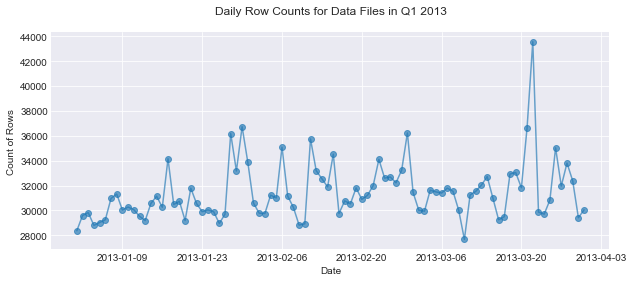

In [176]:
graph1.plot(kind = 'line', figsize = (10,4), alpha = .65, marker = 'o')
plt.title("Daily Row Counts for Data Files in Q1 2013\n")
plt.xlabel('Date')
plt.ylabel('Count of Rows')

### Plot the daily total number of entries & exits across the system for Q1 2013.



In [98]:
graph2 = df_2013_Q1.groupby(df_2013_Q1['Datetime'].dt.date).sum()[['ENTRIES_DIFF', 'EXITS_DIFF']].rename(columns={'ENTRIES_DIFF': 'Entries',
                                                                                                                  'EXITS_DIFF': 'Exits'})

Text(0,0.5,'Total Count per Day')

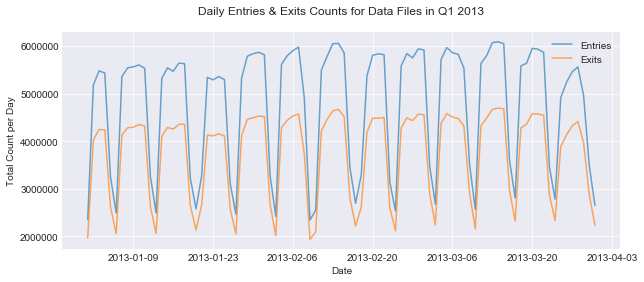

In [121]:
graph2.plot(kind = 'line', figsize = (10,4), alpha = .65)
plt.title("Daily Entries & Exits Counts for Data Files in Q1 2013\n")
plt.xlabel('Date')
plt.ylabel('Total Count per Day')

It is worth noting that the Exits numbers are much lower than Entries due to people leaving through the emergency exits and other noncounting turnstiles methods.

## Plot the mean and standard deviation of the daily total number of entries & exits for each month in Q1 2013 for station 34 ST-PENN STA.



In [101]:
graph3 = df_2013_Q1[df_2013_Q1['Station'] == '34 ST-PENN STA'].groupby(df_2013_Q1['Datetime'].dt.month).agg(['mean', 'std'])[['ENTRIES_DIFF', 'EXITS_DIFF']].rename(columns={'ENTRIES_DIFF': 'Entries',
                                                                                                                  'EXITS_DIFF': 'Exits'})

Text(0,0.5,'Total Count')

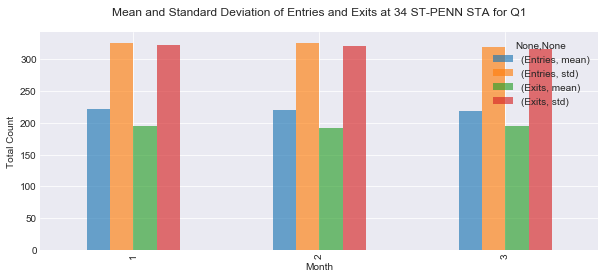

In [127]:
graph3.plot(kind='bar', figsize = (10,4), alpha = .65)
plt.title("Mean and Standard Deviation of Entries and Exits at 34 ST-PENN STA for Q1\n")
plt.xlabel('Month')
plt.ylabel('Total Count')

### Plot 25/50/75 percentile of the daily total number of entries & exits for each month in Q1 2013 for station 34 ST-PENN STA.



In [108]:
graph4 = df_2013_Q1[df_2013_Q1['Station'] == '34 ST-PENN STA'].groupby(df_2013_Q1['Datetime'].dt.month).quantile([.25, .5, .75])[['ENTRIES_DIFF', 'EXITS_DIFF']].rename(columns={'ENTRIES_DIFF': 'Entries',
                                                                                                                  'EXITS_DIFF': 'Exits'})

Text(0,0.5,'Total Count')

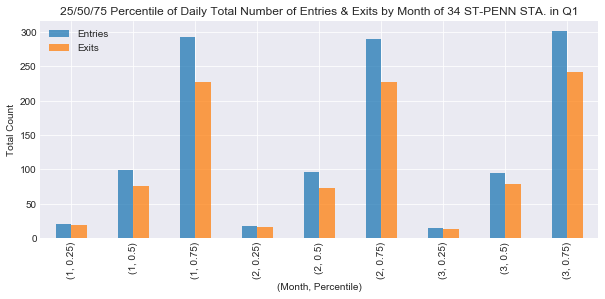

In [180]:
graph4.plot(kind='bar', figsize = (10,4), alpha = .75)
plt.title("25/50/75 Percentile of Daily Total Number of Entries & Exits by Month of 34 ST-PENN STA. in Q1")
plt.xlabel('(Month, Percentile)')
plt.ylabel('Total Count')

### Plot the daily number of closed stations and number of stations that were not operating at full capacity in Q1 2013.



In [139]:
closed_stations['month'] = closed_stations.apply(lambda x: x['Datetime'].month, axis=1)
graph5 = closed_stations[closed_stations['month'].isin([1,2,3])].groupby('Datetime').count()['busyness']

Text(0,0.5,'Total Count of Closed Stations')

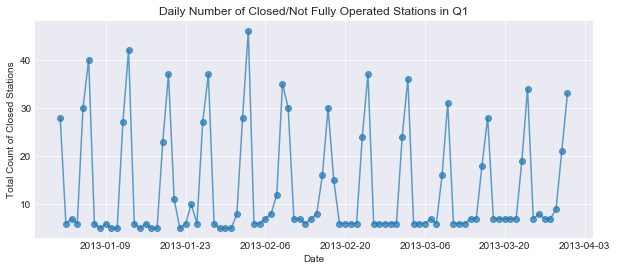

In [179]:
graph5.plot(kind='line', figsize = (10,4), alpha = .7, marker = 'o')
plt.title("Daily Number of Closed/Not Fully Operated Stations in Q1")
plt.xlabel('Date')
plt.ylabel('Total Count of Closed Stations')